# Prototype for simple fits using gv_lsqfit

### Code description
### #This gives a simple implementation gv_lsqfit. It has 2 types of fits implemented.
#### Also, gives outliers and prediction using fit function (with errors).
### How to use this:
- To try out a fit with a new function, 
    - Just define f_func
    - Gather data into structures.
    - Perform the fits.
- To play with a list of standard functions, use the other file 'complex_gv_lsqfit.ipynb'

## Index:
* [functions](# func)
* [fit1](# fit1)

In [1]:

import numpy as np
import scipy as sp
import pandas as pd
import glob
import os
import pickle

# Graphics
%matplotlib notebook
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

import itertools


import lsqfit
import gvar as gv

# Code for neat formatting.
from IPython.display import display, HTML, Markdown
def printmd(string):
    display(Markdown(string))




<a id = ' func'></a>
### The functions used in fit and plot

In [2]:
# Functions for performing Fit and plot.
   
def f_make_p0(par):
    p0=par.copy()
    return p0

    
def f_fit_plot(x,y,all_dta,fit,error_band=False,semilog=False,full_data=True):
    '''
    Function for plotting data with the fit lines and error bands.
    For correlators, using a semi-log plot.
    full_data=True, plots the entire data and the best-fit in the fit region
    '''

    plt.figure()
    # Plots data points
    if full_data: # Plot all the correlators even those not used in the fit.
        plt.errorbar(x=all_dta['x'],y=gv.mean(all_dta['y']),yerr=gv.sdev(all_dta['y']),color='black',linestyle='None',marker='o')
    else:         # Plot the data points used in the fit
        plt.errorbar(x=x['x'],y=gv.mean(y['y']),yerr=gv.sdev(y['y']),linestyle='None',color='red',marker='s')
    
    # Plot the best fit line
    # # Using a finer grid to get a continuous curve.
    curvex=dict(x)
    curvex['x']=np.linspace(min(fit.x['x']),max(fit.x['x']),500)
    curvey=gv.mean(fit.fcn(curvex,fit.p))
    plt.plot(curvex['x'],curvey,color='blue')

    if error_band:
        obs_fit=gv.mean(fit.fcn(curvex,fit.p))
        err_fit=gv.sdev(fit.fcn(curvex,fit.p))  
        sigma=2.0
        plt.fill_between(curvex['x'],obs_fit-sigma*err_fit,obs_fit+sigma*err_fit,color='yellow') # providing an error band.

    if semilog: plt.semilogy()
   
    plt.title("Plot")

def f_perform_fit(all_dta,x,y,verbose=True,plot=True,full_data=False,error_band=False,semilog=False):
    
    '''
    Function wrapper to perform correlator fit for mesons.
    Reads dictionary dta with x and y data.
    Performs both cosh and sinh fits.
    '''
    
    print "*****************************",'\n'
    # Performing meson fit
    
    p0=f_make_p0(par)
    fit = lsqfit.nonlinear_fit(data=(x, y['y']), fcn=f_func, p0=p0,extend=True,svdcut=1e-8)
    
    # Print the fit results
    if verbose: 
        print f_func.__doc__.strip('\n').strip('  ') # Prints the functional form of fit function.
        print(fit.format(maxline=True)),"\n\n"

    else :
        print fit,"\n\n"
    
    # Plot fit
    if plot: f_fit_plot(x,y,all_dta,fit,full_data=full_data,error_band=error_band,semilog=semilog)

    return fit

# Code to find outlier
def f_outlier_list(fit):
    ''' Code to find outliers in a fit
    Reads fit and returns list of indices of outliers.
    '''
    y_th=fit.fcn(fit.x,fit.p)
    y_exp=fit.y
    outlier_list=[]
    for i,(j,k) in enumerate(zip(y_exp,y_th)):
        # Find points with chi-square more than 3.
        if gv.chi2(j,k)>3.0:
            outlier_list.append(i)

    return outlier_list

## Data structures:
- all_dta : storing full data. Useful for plot.
- dta : storing data to fit. Dictionary {'x':,'y':gvar(val(err))}
- p0 : Initial parameter guess.

-------------------------------------------------
-------------------------------------------------
## Simple peak fit of data
<a id = ' fit1'></a>

In [3]:
## Peak fit 

### The most basic way to define functions. This needs to be modified at 3 places, each time you change your function.
def f_func(x,p):
    '''
    f(x)=chi_p + a1 (x-U_p)^2 + a2 (x-U_p)^3  + a3 (x-U_p)^4
    '''
    
    x=x['x']    
    a1,a2,a3=p['a1'],p['a2'],p['a3']
    chi_p,Up=p['chi_p'],p['Up']
    
    ans=chi_p + a1 *(x-Up)**2 + a2 *(x-Up)**3  + a3 *(x-Up)**4
    return ans


## A simplified way using exec to dynamically define variables, which requires minimal modification.

def f_func(x,p):
    '''
    f(x)=chi_p + a1 (x-U_p)^2 + a2 (x-U_p)^3  + a3 (x-U_p)^4
    '''
    x=x['x']
    
    # Code to dynamically define variables    
    for key,val in p.items():
        exec(key + '=val')
    
#     a1,a2,a3=p['a1'],p['a2'],p['a3']
#     chi_p,Up=p['chi_p'],p['Up']
    
    ans=chi_p + a1 *(x-Up)**2 + a2 *(x-Up)**3  + a3 *(x-Up)**4
    return ans

***************************** 

f(x)=chi_p + a1 (x-U_p)^2 + a2 (x-U_p)^3  + a3 (x-U_p)^4

Least Square Fit (no prior):
  chi2/dof [dof] = 2.1 [2]    Q = 0.12    logGBF = None

Parameters:
             a1        390 (35)      [    1 +- inf ]  
             a3   20747 (19131)      [ 0.04 +- inf ]  
             a2    -5603 (2647)      [    1 +- inf ]  
             Up      0.326 (37)      [  0.4 +- inf ]  
          chi_p       2.88 (49)      [    1 +- inf ]  

Fit:
      key         y[key]      f(p)[key]
---------------------------------------
        0    3.2319 (50)    3.2326 (50)  
        1    3.3127 (47)    3.3097 (40)  
        2    3.3511 (43)    3.3566 (29)  *
        3    3.3740 (40)    3.3689 (30)  *
        4    3.3443 (37)    3.3469 (26)  
        5    3.2971 (35)    3.2964 (32)  
        6    3.2275 (34)    3.2276 (34)  

Settings:
  svdcut/n = 1e-08/0    reltol/abstol = 0.0001/0*    (itns/time = 34/0.0)





<IPython.core.display.Javascript object>


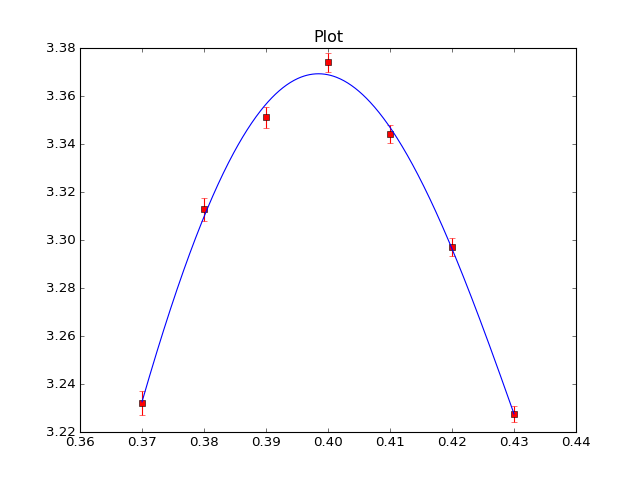

In [4]:
if __name__ == '__main__': 
    # Extract data from file.
    data_dir='test_data/'
    df2=pd.read_csv(data_dir+'SUS_1',sep='\t',names=['U','L','sus','dsus']).reset_index().drop('index',1)
    
    # Trim data
    df3=df2[df2.L==32][['U','sus','dsus']]
    all_dta={'x':df3.U.values,'y':gv.gvar(df3.sus.values,df3.dsus.values)}

    df=df3[(df3.U>0.35) & (df3.U<0.44)]
    dta=df.as_matrix().astype(np.float64)[1:]
    xdata,ydata,yerr=dta[:,0],dta[:,1],dta[:,2]
#     print xdata,ydata,yerr
    x,y={'x':xdata},{'y':gv.gvar(ydata,yerr)}
    
### Actual fitting of data.
if __name__ == '__main__': 
    # Initial guesses for parameters.
    par={'chi_p':1,'Up':0.4,'a1':1,'a2':1,'a3':0.04}

    fit=f_perform_fit(all_dta,x,y,verbose=True,plot=True,full_data=False,error_band=False,semilog=False)


###  Outliers

In [5]:
## Looking at outliers
if __name__ == '__main__': 
    print f_outlier_list(fit)
    df.iloc[f_outlier_list(fit),:]


[3]


## Prediction using fit function

In [6]:
# Write parameter list to dictionary
if __name__ == '__main__': 
    ft_p = gv.BufferDict(**{par: fit.p[par] for par in par})
    
    print ft_p
    # ## Write dictionary
    # pickle.dump(fr_p, open("best_fit.p", "wb"))

    # ## Read dictionary
    # ft_t = pickle.load(open("best_fit.p", "rb"))
    # ft_t    


    # Prediction 
    xdict={'x':127}
    print fit.fcn(xdict,ft_p)

{'a1': 390(35),'a3': 20747(19131),'a2': -5603(2647),'Up': 0.326(37),'chi_p': 2.88(49)}
5.3(4.9)e+12
